# Chapter 7. Ensemble Learning & Random Forests

Project Goal: Ensemble方法(bagging, boosting, stacking), 以及 Random Forests

# Voting Classifiers (投票分類器)

為什麼 Ensemble 可以提高準確度, 即使個別的分類器之準確率都不高？
* 一個正常的硬幣, 正面與反面的機率都是50%
* 假設有一個硬幣, 正面的機率是51%, 反面49%, 則 在投擲數量極大時, 正面次數大於反面次數的機率會非常高, 如下所示
* 這就是 大數法則(Law of Large Numbers)

所以, 當我們在訓練各個預測器時, 盡可能讓他們彼此獨立, 去犯不同類型的錯誤, 可以更好的提升準確度

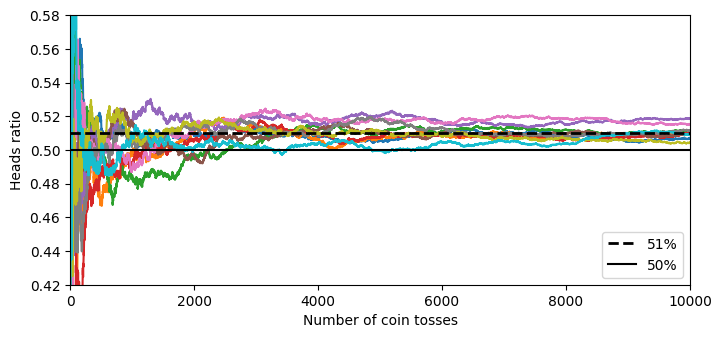

In [1]:
import numpy as np
import matplotlib.pyplot as plt

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# np.cumsum: 累加, 也就是 [1, 2, 3, 4] 變成 [1, 3, 6, 10]
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

# 由下圖可見, 當投擲次數超過3000次後, 正面多於反面的機率就幾乎為100%了
# 這就是大數法則的原理！

隨意選擇三種分類器來做 ensemble

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='hard'
)
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# 由輸出可見, VotingClassifier (Ensemble) 的準確率會高於個別三者

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Hard Voting v.s. Soft Voting:
* voting='hard' 代表 硬投票, 從各個分類器挑出出現次數最多的結果作為預測
* voting='soft' 代表 軟投票, 從各個分類器挑出出現機率最高的結果作為預測

In [4]:
# 軟投票 v.s. 硬投票
# 通常軟投票的效果會優於硬投票! 因為考慮機率的話, 高信心的票選會具有更高權重

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging & Pasting

除了用不同的演算法之外, 也可以用不同的訓練資料隨機子集合來訓練, 最後再將所有預測器的結果以統計模式 (statistical mode) 函數匯總 (以最常見者為預測)
* Bagging (Bootstrap Aggregating): 取完會放回(一個資料可能會被重複抽取)
* Pasting: 取完不放回

原理上, 同樣是利用多個偏差比原始訓練組還高的子訓練組來做 ensemble, 最終結果中, 偏差與使用原訓練組的結果差不多, 但變異度會更低

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# n_estimators: 有多少個 decision tree
# max_samples: 每個 decision tree 用多少筆資料訓練 (或是多少比例的資料)
# bootstrap: True 代表 bagging; False 代表 pasting
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100, bootstrap=True, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("Accuracy WITH bagging: ", accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Accuracy WITHOUT bagging: ", accuracy_score(y_test, y_pred_tree))

Accuracy WITH bagging:  0.904
Accuracy WITHOUT bagging:  0.856


比較單一決策樹與bagging決策樹的決策邊界

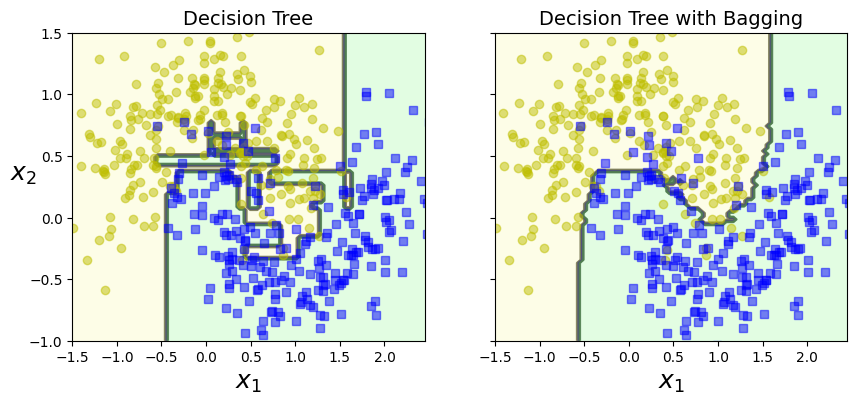

In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

# 下圖中, 左圖是單一決策樹, 右圖是包含500棵決策樹的bagging整體
# 可以看出, bagging的預測類推能力遠優於單一決策樹, 決策邊界也更規則

Bagging 還是 Pasting?

通常來說, bagging 的偏差會略高於 pasting, 但由於 bagging 的子集合多樣性更高, 代表各個預測器之間的相關性更低, 可以降低整體的變異度。 故, bagging 通常可以產生較佳的模型, 但也可以交叉驗證來評估兩者, 再選擇效果更好者。

# Out-of-Bag 評估

因為預測器可能多次抽出同一群實例, 所以通常會有一群實例從頭到尾都沒有被抽到, 這些剩下的稱為 out-of bag (oob) 實例(通常佔原先資料組的37%), 我們可以順便用這些實例當作驗證組來評估模型的成效

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, oob_score=True, random_state=40
)
bag_clf.fit(X_train, y_train)
print("Accuracy tested with out-of-bag: ", bag_clf.oob_score_)
y_pred = bag_clf.predict(X_test)
print("Accuracy tested with testing set: ", accuracy_score(y_test, y_pred))

# 由結果可見, out-of-bag 實例測出的準確度跟實際測試集測出的相差不多
# 所以 oob 確實可以作為 validation set!

Accuracy tested with out-of-bag:  0.8986666666666666
Accuracy tested with testing set:  0.912


# Random Patches & Random Subspaces

* bagging 除了可以對實例進行隨機抽樣外, 也可以拿來對特徵進行隨機抽樣(由bootstrap_features, max_features參數控制)
* 若同時抽出 實例 與 特徵, 稱為 Random Patches(隨機補丁)
* 保留所有訓練實例(bootstrap=False, max_samples=1.0) 但 抽樣特徵(bootstrap_features=True, max_features < 1.0), 稱為 隨機子空間(Random Subspaces)

# Random Forests

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print("Accuracy of Random Forests", accuracy_score(y_test, y_pred_rf))

0.92


In [ ]:
# 其實 random forests 就等於以下的寫法

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), 
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

# Extra-Trees (極端隨機樹)

如果讓 tree nodes 切分的方式從 尋找到的最佳閾值 改為 完全隨機, 就可以進一步讓隨機森林有更高的偏差, 也就有更低的變異度, 這種森林稱作 extra-trees (極端隨機樹)
* 因為不需要花時間找到最佳閾值, 故 訓練速度更快, 但與 random forest 的準確度不一定誰高誰低, 所以都該試試看
* sklearn 中有 ExtraTreesClassifier 及 ExtraTreesRegressor 可以用

# 特徵的重要性

In [12]:
# RandomForestClassifier.feature_importances_ 可以顯示各特徵的重要程度
# 以先前的 Iris資料組 為例
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.1053871827799318
sepal width (cm) 0.02430915746866093
petal length (cm) 0.421595824192443
petal width (cm) 0.4487078355589643


# Boosting (Hypothesis Boosting, 增強)

boosting, 是指把多個弱學習器組合起來, 變成一個強學習器, 讓依序訓練學習器時, 每一次訓練都試著修正前一個預測器。常見的 boosting 有 AdaBoost 及 Gradient Boosting。

# AdaBoost (Adaptive Boosting)

在修正上一個預測器時, 會特別注意上一個預測器 underfitting 的實例, 提升被錯誤分類之實例的權重

* 先算出第j個預測器的加權錯誤率: r_j = (Σ w_error) / (Σ w)
* 再計算出新的權重: a_j = η * log((1 - r_j) / r_j) , 其中 η = learning ratee
* 再將錯誤預測者的 w 更新為 w * exp(a_j), 並做正規化(所有weight和為1)

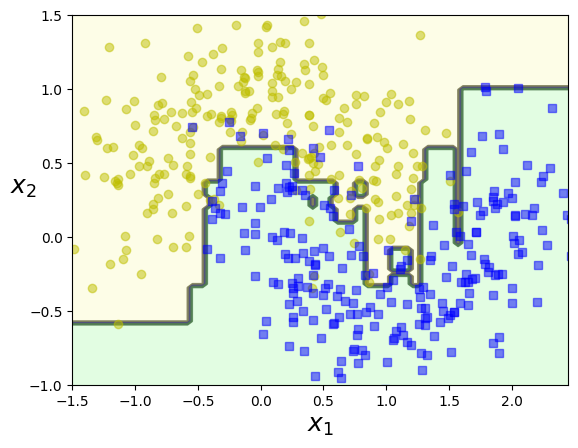

In [13]:
# 200 個決策樹樁訓練成的 AdaBoost Classifier, 其中每棵樹都只有2個 node
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

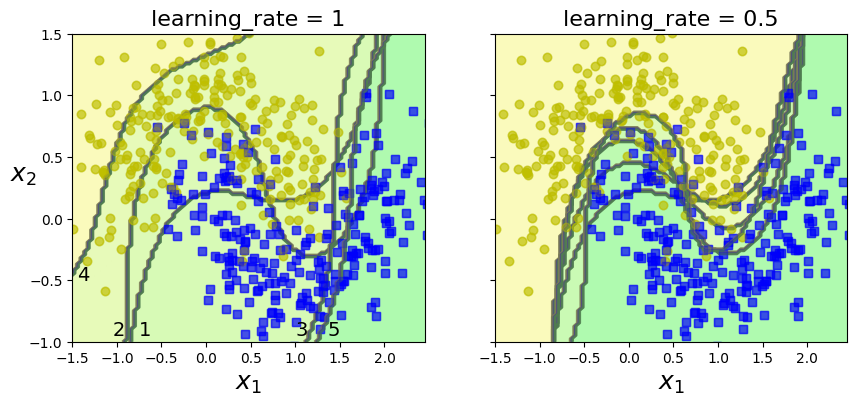

In [14]:
# 比較 learning rate = 1 與 0.5 之間的差別

m = len(X_train)
fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

# 由下圖可以看出, learning rate 降到 0.5 時 (即 每次迭代都會把錯誤分類的實例提升一半的權重), 分類效果會愈來愈好

# Gradient Boosting (梯度增強)

與 AdaBoost 一樣, 都是在每次加入新預測器時修正前一個預測器, 但與AdaBoost調整權重不同, 梯度增強會試著讓新的預測器擬合上一個預測器的殘差 (residual error, 預測值減去實際值的差)

In [22]:
# 先來了解 gradient boosting 的原理
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

# 第一棵樹是正常的 decision tree
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
# 取第一棵樹預測完的殘差來訓練第二棵樹
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)
# 取第二棵樹預測完的殘差來訓練第三棵樹
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
# 最後再加總三棵樹的預測
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print("Prediction:", y_pred)

Prediction: [0.75026781]


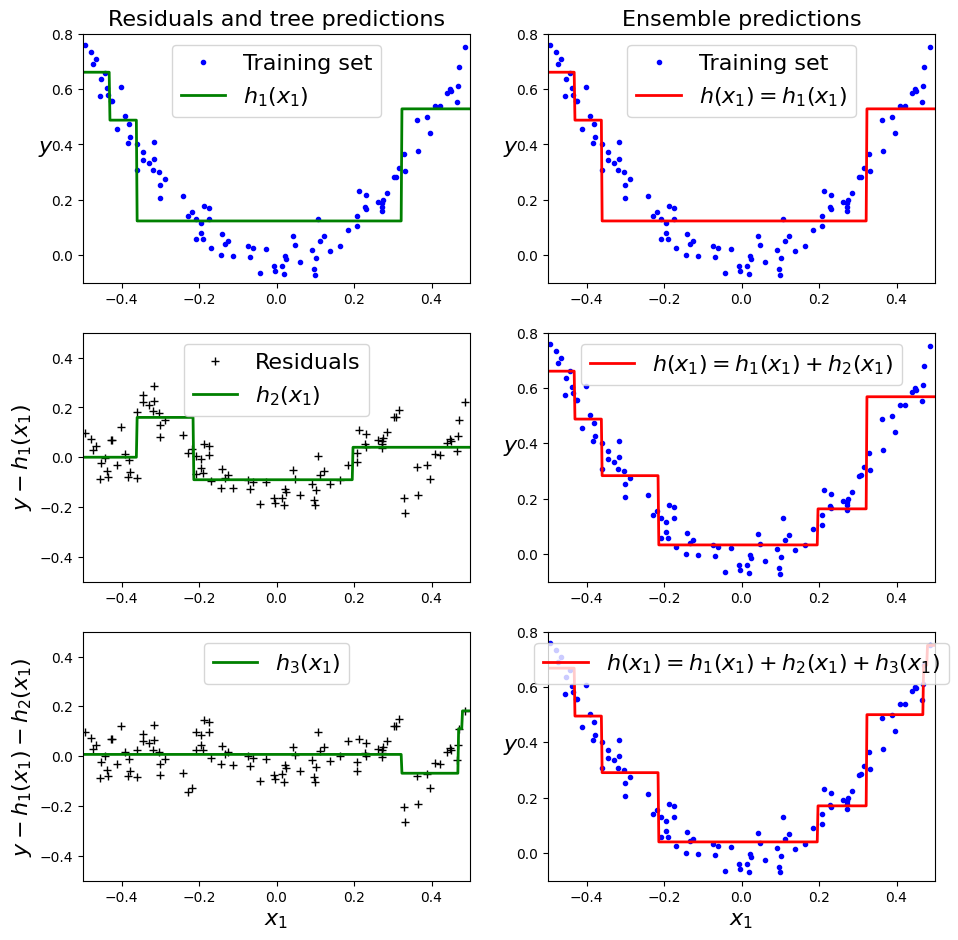

In [18]:
# 圖像化三棵樹的預測, 以及整體的預測
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

# 下圖的左邊分別為 y, y2, y3 三個個別的預測, 右邊是預測的總和
# 可以看到, 隨著愈來愈多棵樹加入, 預測結果也會愈來愈好

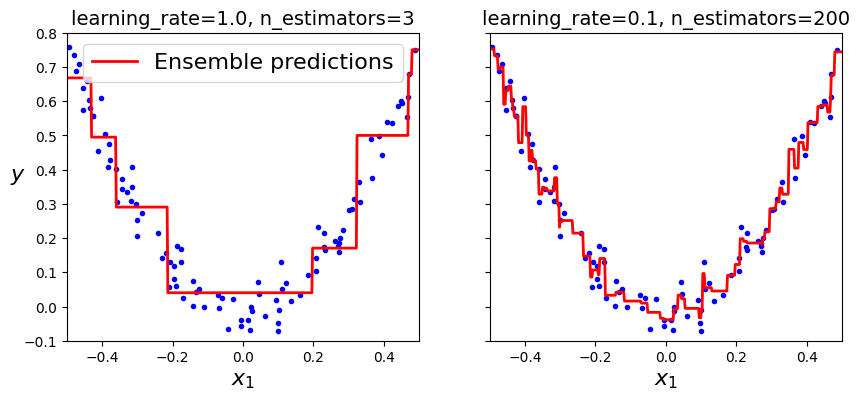

In [23]:
# 實際使用 Gradient Boosting Regressor
# 比較 learning rate 及 n_estimators 參數的調整結果

from sklearn.ensemble import GradientBoostingRegressor

# GBRT: Gradient Boosted Regression Tree
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, 
                                      learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

# 下圖中, 左圖為 n_estimators=3 的結果, 可以看出因為預測器不夠多所以 underfitting
# 右圖為 n_estimators=200 的結果, 可以看出預測器太多所以 overfitting
# 至於 learning rate 的大小, 愈小時代表需要更多樹才能擬合, 但通常效果會更好

In [24]:
# 再加上 early stopping, 若連續五個 epoch 都沒有進步就停止

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# warm_start: 當 True 時, 會在每一次 fit 後都會保存下來既有的樹
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break                    # early stopping

print("Stop when n_estimators =", gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

Stop when n_estimators = 61
Minimum validation MSE: 0.002712853325235463


除此之外, 也可以透過調整 GradientBoostingRegressor 中的 subsample 參數, 以指定比例的實例來訓練 (也就是以更高的偏差來換取更低的變異度), 稱為 Stochastic Gradient Boosting (隨機梯度增強)

# XGBoost (Extreme Gradient Boosting)

In [25]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(X_val, y_pred)
print("Validation MSE =", val_error)

Validation MSE = 0.25764105241381147


In [26]:
# 加上 early stopping

xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# Stacking (Stacked Generalization)

p.204 ~ p.207 介紹了 stacking 的概念, 但因為目前 sklearn 不支援, 所以沒有範例程式
* 但有時間可以自己研究！